## Embedding viz

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-16 12:09:25.890011: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 12:09:27.299132: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 12:09:27.968731: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 12:09:27.970061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 14.6%
RAM Usage: 12.2%
Available RAM: 884.3G
Total RAM: 1007.0G
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA A100-SXM4-80GB - Memory Allocated: 0.00 GB


### Setup

In [6]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric
from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

from data.data_viz import plot_umap_embeddings_w_fc

Loading data...


Number of components for 95% variance PCA: 27


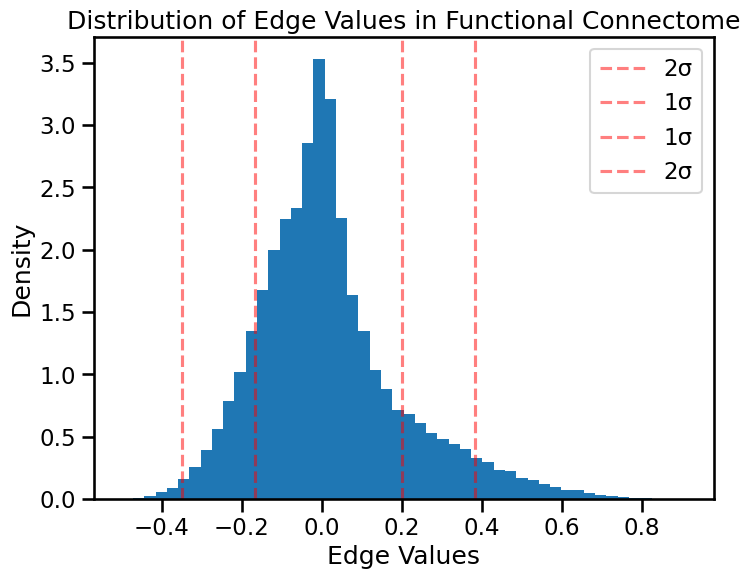

In [7]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_umap_embeddings_w_fc

### SMT POOL EMBEDDINGS ###
from models.smt import SharedSelfAttentionPoolingModel, SharedSelfAttentionCLSPoolingModel

# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')

### PCA ###
X_pca = load_transcriptome(parcellation='S456', run_PCA='95var', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X_valid = X[valid_indices]
X_pca = X_pca[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Plot histogram of edge values
plt.figure(figsize=(8, 6))
plt.hist(Y.flatten(), bins=50, density=True)

# Add std dev markers
mean = np.mean(Y)
std = np.std(Y)
for i in [-2, -1, 1, 2]:
    plt.axvline(mean + i*std, color='r', linestyle='--', alpha=0.5, 
                label=f'{i}σ' if i > 0 else f'{abs(i)}σ')

plt.xlabel('Edge Values')
plt.ylabel('Density')
plt.title('Distribution of Edge Values in Functional Connectome')
plt.legend()
plt.show()

PCA and PLS

In [18]:
# Project X to PCs explaining 95% variance explained
print(f"X_pca shape: {X_pca.shape}")

### PLS ###
# Project X to 10 PLS components
pls_model = PLSRegression(n_components=10, max_iter=1000, scale=True)
pls_model.fit(X_valid, Y_valid)

# Use x_rotations_ for fixed projection like in PLSEncoder
X_pls = np.matmul(X_valid, pls_model.x_rotations_)
print(f"X_pls shape: {X_pls.shape}")

X_pca shape: (455, 27)
X_pls shape: (455, 10)


In [19]:
# prepare data loader
X = torch.tensor(X_valid, dtype=torch.float32).to("cuda") 
coords = torch.tensor(coords_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X, coords)
dataloader = DataLoader(dataset, batch_size=X_valid.shape[0], shuffle=False)

SMT

In [20]:
from models.smt import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

# SMT EMBEDDINGS - 3 versions ###
smt_model_v1 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

smt_model_v2 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

smt_model_v3 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

# Load weights and prepare models
for i, model in enumerate([smt_model_v1, smt_model_v2, smt_model_v3], 1):
    model_path = f"/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_full{i}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cuda")
    model.encoder.eval()

embeddings_smt_v1, embeddings_smt_v2, embeddings_smt_v3 = [], [], []
with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        embeddings_smt_v1 = smt_model_v1.encoder(batch[0]).cpu().numpy()
        embeddings_smt_v2 = smt_model_v2.encoder(batch[0]).cpu().numpy()
        embeddings_smt_v3 = smt_model_v3.encoder(batch[0]).cpu().numpy()

# SMT CLS EMBEDDINGS - 3 versions ###
smt_cls_model_v1 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

smt_cls_model_v2 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

smt_cls_model_v3 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

# Load weights and prepare models
for i, model in enumerate([smt_cls_model_v1, smt_cls_model_v2, smt_cls_model_v3], 1):
    model_path = f"/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smtcls_full{i}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cuda")
    model.encoder.eval()

embeddings_smt_cls_v1, embeddings_smt_cls_v2, embeddings_smt_cls_v3 = [], [], []
with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        embeddings_smt_cls_v1, _ = smt_cls_model_v1.encoder(X, coords, return_attn=True)
        embeddings_smt_cls_v1 = embeddings_smt_cls_v1.cpu().numpy()
        embeddings_smt_cls_v2, _ = smt_cls_model_v2.encoder(X, coords, return_attn=True)
        embeddings_smt_cls_v2 = embeddings_smt_cls_v2.cpu().numpy()
        embeddings_smt_cls_v3, _ = smt_cls_model_v3.encoder(X, coords, return_attn=True)
        embeddings_smt_cls_v3 = embeddings_smt_cls_v3.cpu().numpy()

  warnings.warn(



Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in SMT model: 2162315


  warnings.warn(



Number of learnable parameters in SMT w/ CLS model: 2173067
Number of learnable parameters in SMT w/ CLS model: 2173067
Number of learnable parameters in SMT w/ CLS model: 2173067


In [21]:
smt_model = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=512, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

model_path = f"/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_full_final.pt"
smt_model.load_state_dict(torch.load(model_path))  # Fixed: Changed model to smt_model
smt_model.eval()
smt_model.to("cuda")
smt_model.encoder.eval()

embeddings_smt = []
with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        embeddings_smt = smt_model.encoder(batch[0]).cpu().numpy()

  warnings.warn(



Number of learnable parameters in SMT model: 2162315


In [22]:
# smt_compressed_model = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, encoder_output_dim=3, d_model=128,
#                                           nhead=4, num_layers=4,
#                                           deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
#                                           dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
#                                           batch_size=512, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

# model_path = f"/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_full_final_compressed.pt"
# smt_compressed_model.load_state_dict(torch.load(model_path))
# smt_compressed_model.eval()
# smt_compressed_model.to("cuda")
# smt_compressed_model.encoder.eval()

# embeddings_smt_compressed = []
# with torch.no_grad():
#     for batch in dataloader:
#         X, coords = batch
#         embeddings_smt_compressed = smt_compressed_model.encoder(batch[0]).cpu().numpy()

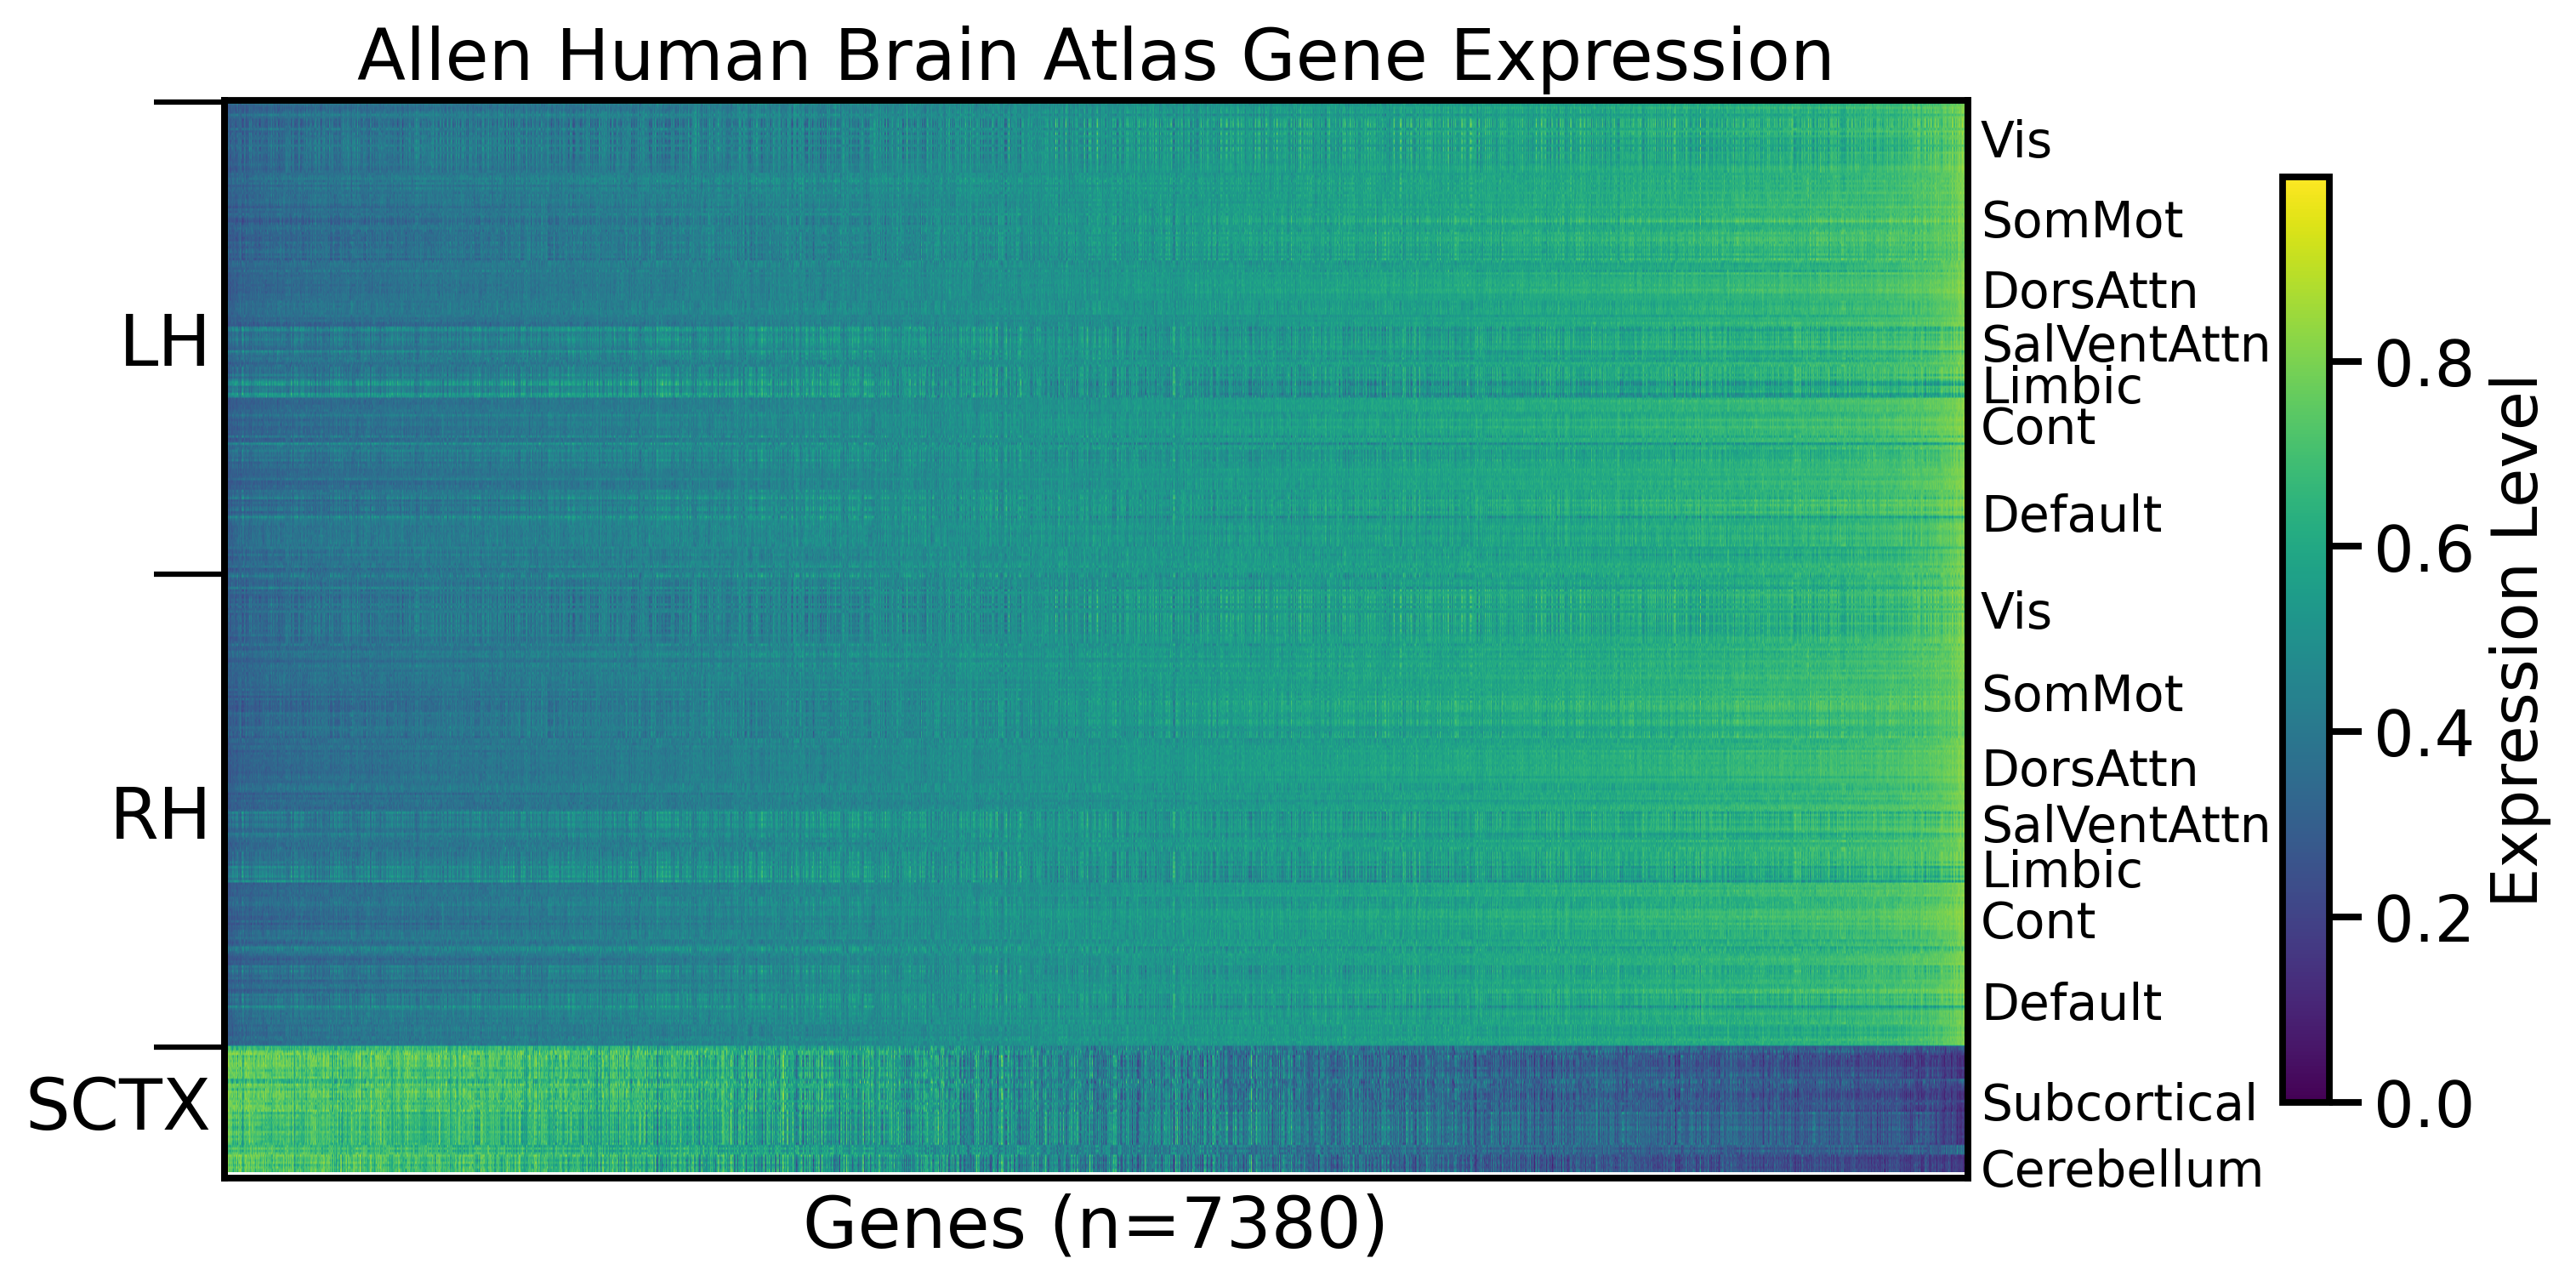

In [23]:
plot_transcriptome(parcellation='S456', gene_list='0.2', dataset='AHBA', run_PCA=None, 
                      omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', 
                      sort_genes='expression', null_model='none', random_seed=42, 
                      cmap='viridis', title='Allen Human Brain Atlas Gene Expression', fontsize=20, 
                      add_hemisphere_labels=True, add_network_labels=True, jupyter=True)

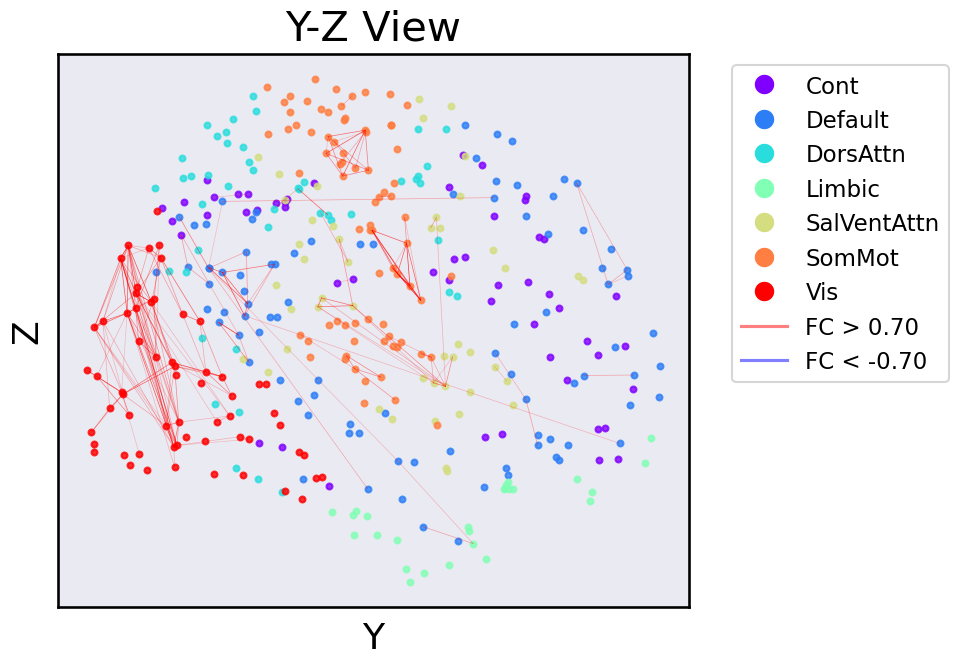

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



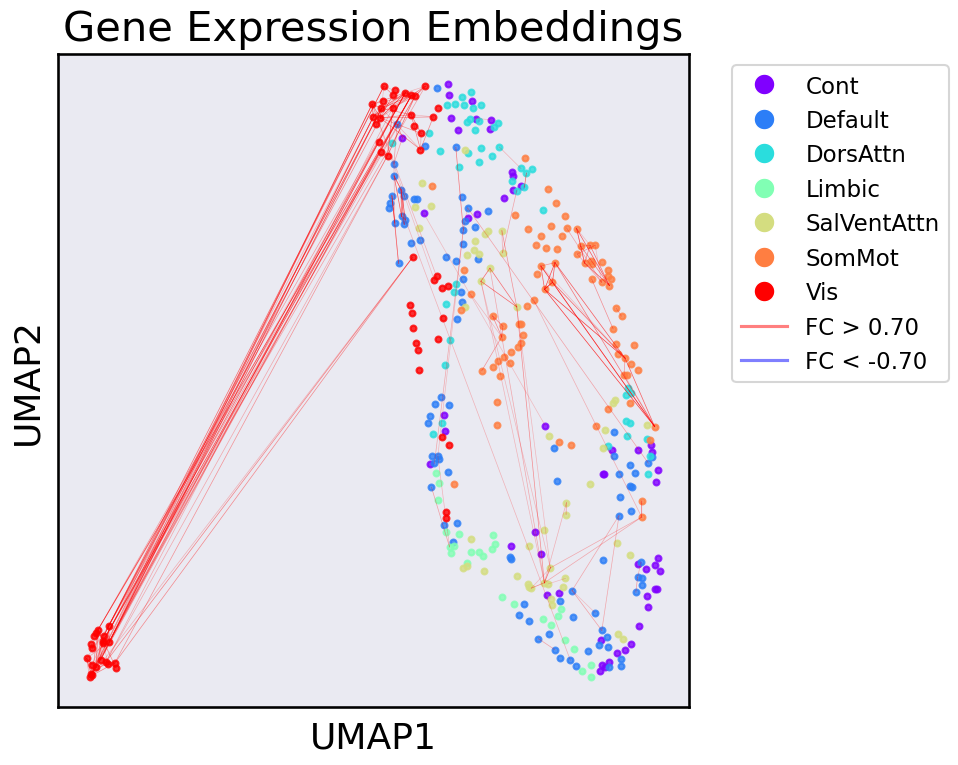

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



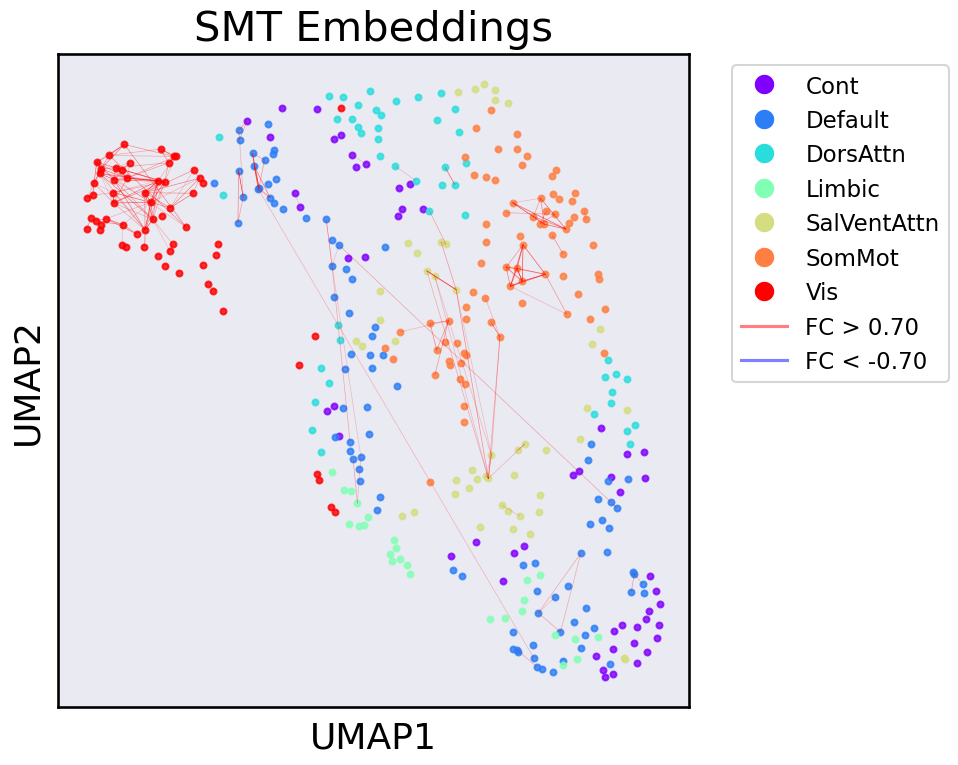

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



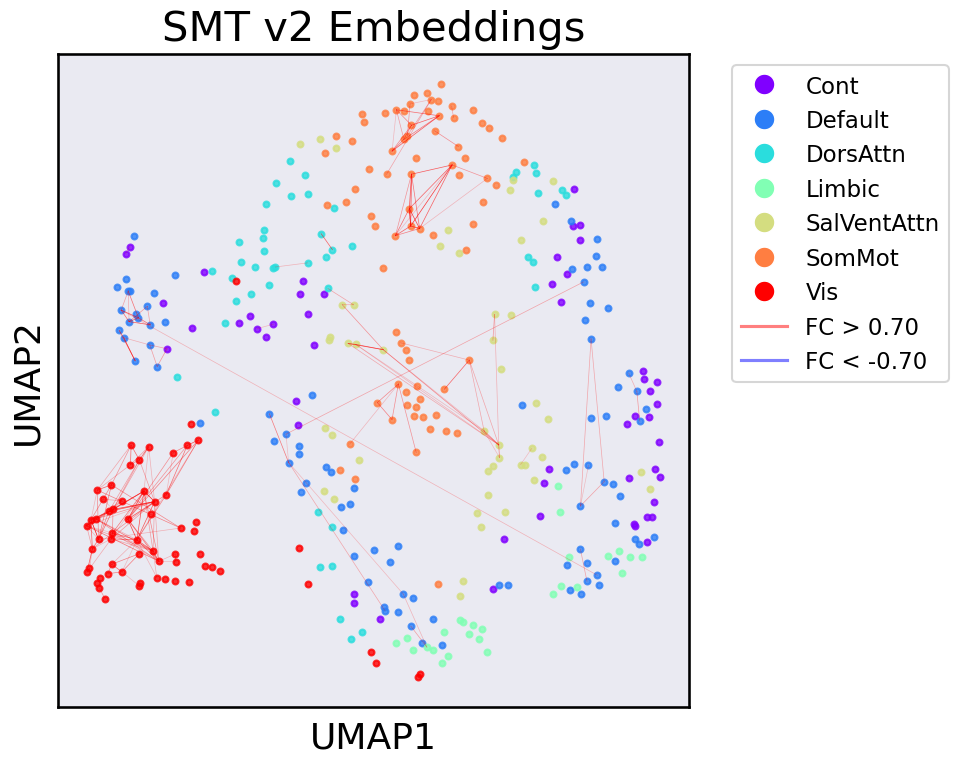

In [34]:
from data.data_viz import plot_coords_w_fc, plot_umap_embeddings_w_fc

omit_subcortical = True
neg_threshold, pos_threshold = -0.7, 0.7

coords_np = coords.cpu().numpy()
plot_coords_w_fc(coords_np, network_labels, dims=(1,2), conn_matrix=Y_valid, 
                 edge_threshold=(neg_threshold, pos_threshold), 
                 title="Y-Z View",
                 omit_subcortical=omit_subcortical)

# Raw gene expression data
plot_umap_embeddings_w_fc(X_valid, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         title="Gene Expression Embeddings", 
                         omit_subcortical=omit_subcortical)

'''
# PCA embeddings 
plot_umap_embeddings_w_fc(X_pca, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         title="PCA Embeddings", 
                         omit_subcortical=omit_subcortical)
'''
# SMT embeddings 
plot_umap_embeddings_w_fc(embeddings_smt, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         title="SMT Embeddings", 
                         omit_subcortical=omit_subcortical, flip_umap1=True)

# SMT v2 embeddings 
plot_umap_embeddings_w_fc(embeddings_smt_v2, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         title="SMT v2 Embeddings", 
                         omit_subcortical=omit_subcortical, flip_umap1=True, flip_umap2=True)

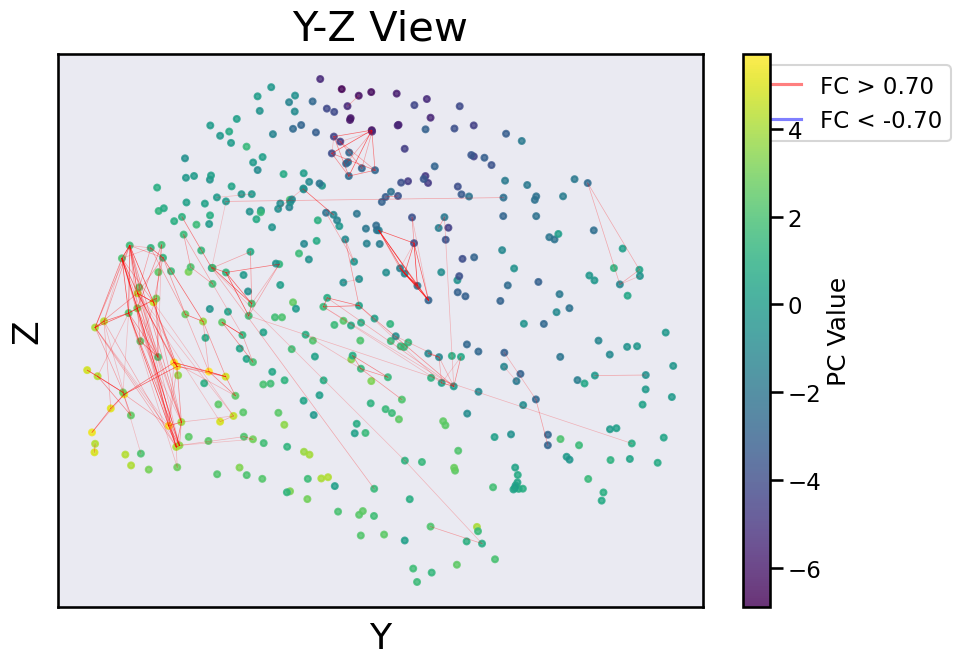

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



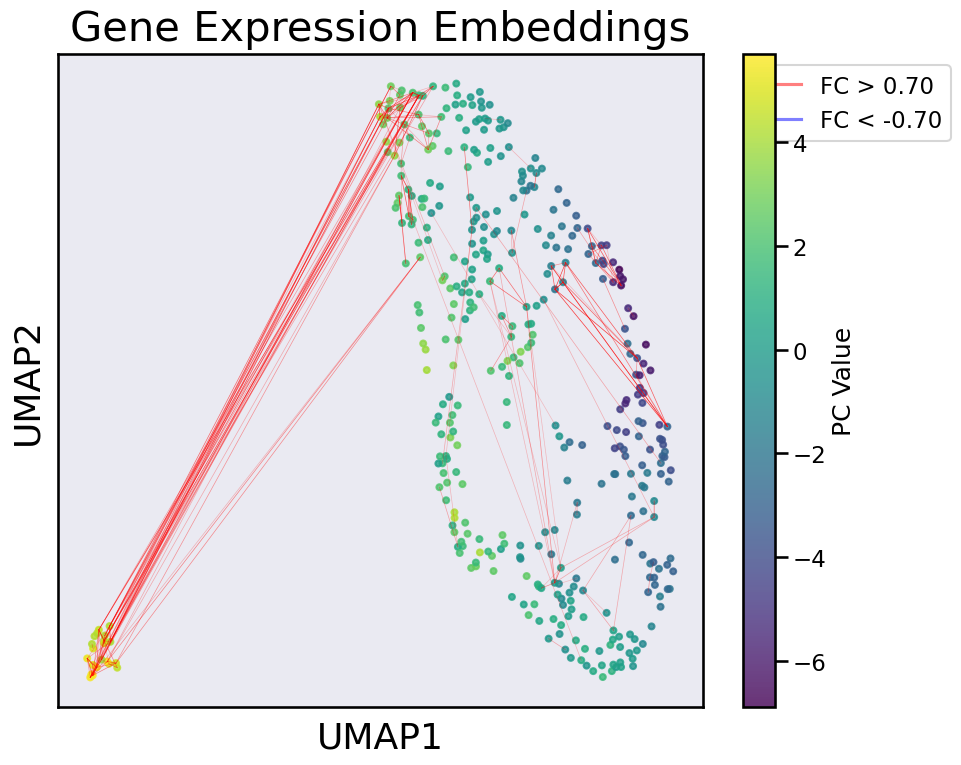

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



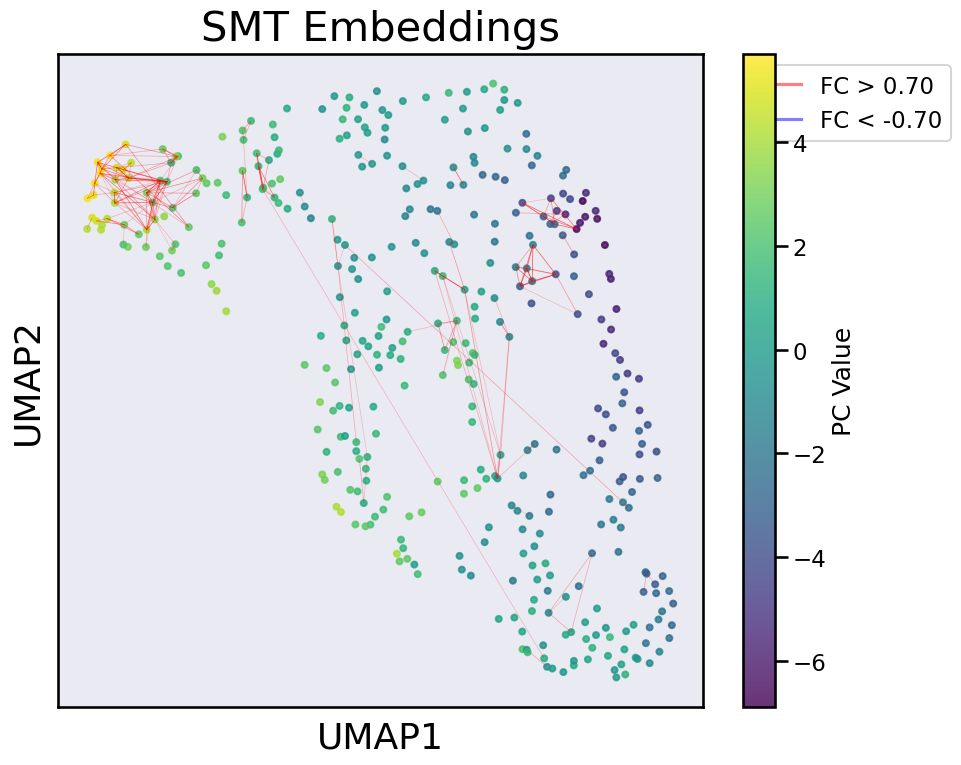

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



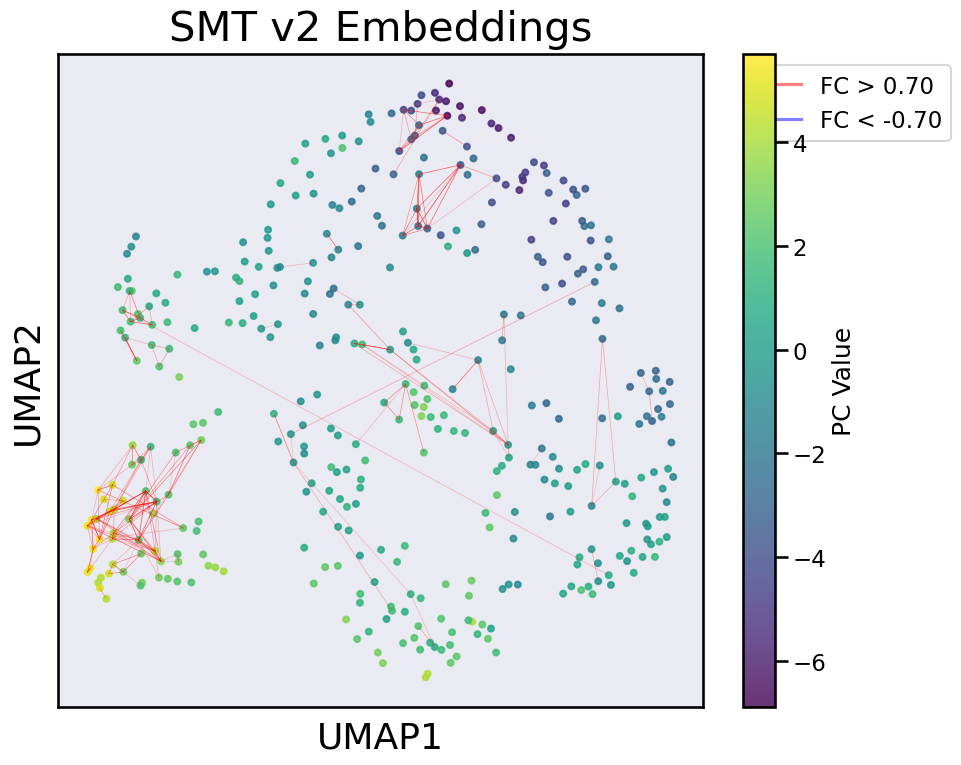

In [35]:
pc_values = X_pca[:, 2]
plot_coords_w_fc(coords_np, network_labels, dims=(1,2), conn_matrix=Y_valid, pc_values=pc_values, 
                 edge_threshold=(neg_threshold, pos_threshold), 
                 title="Y-Z View",
                 omit_subcortical=omit_subcortical)

# Raw gene expression data
plot_umap_embeddings_w_fc(X_valid, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         pc_values=pc_values,
                         title="Gene Expression Embeddings", 
                         omit_subcortical=omit_subcortical, )

# SMT embeddings 
plot_umap_embeddings_w_fc(embeddings_smt, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         pc_values=pc_values,
                         title="SMT Embeddings", 
                         omit_subcortical=omit_subcortical, flip_umap1=True,)

# SMT embeddings 
plot_umap_embeddings_w_fc(embeddings_smt_v2, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         pc_values=pc_values,
                         title="SMT v2 Embeddings", 
                         omit_subcortical=omit_subcortical, flip_umap1=True, flip_umap2=True)


In [27]:
# Per subnetwork SMT > Bilinear gains
mean_gains = {
    'Vis': 0.088,
    'SomMot': 0.081, 
    'DorsAttn': 0.063,
    'SalVentAttn': 0.061,
    'Limbic': 0.044,
    'Cont': 0.054,
    'Default': 0.047,
    'Subcortical': 0.036,
    'Cerebellum': 0.058
}

intra_network_gains = {
    'Vis': 0.11,
    'SomMot': 0.11,
    'DorsAttn': 0.071,
    'SalVentAttn': 0.069,
    'Limbic': 0.035,
    'Cont': 0.057,
    'Default': 0.040,
    'Subcortical': 0.032,
    'Cerebellum': 0.035
}

inter_network_gains = {
    'Vis': 0.069,
    'SomMot': 0.056,
    'DorsAttn': 0.055,
    'SalVentAttn': 0.054,
    'Limbic': 0.054,
    'Cont': 0.051,
    'Default': 0.055,
    'Subcortical': 0.041,
    'Cerebellum': 0.082
}

  legend_elements.extend([



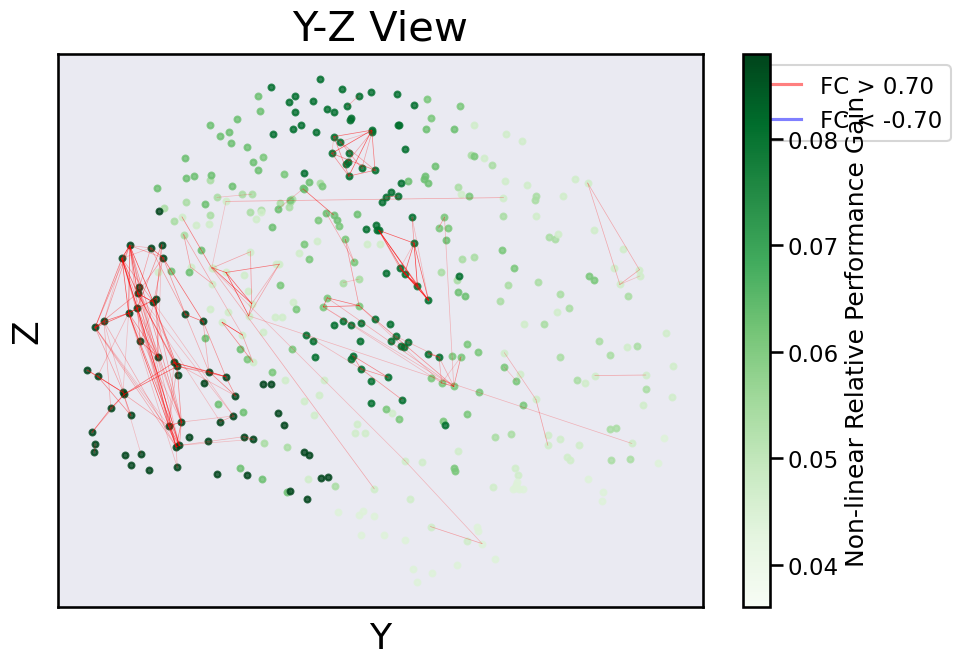

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  plt.colorbar(sm, label='Performance Gain (Pearson r)')



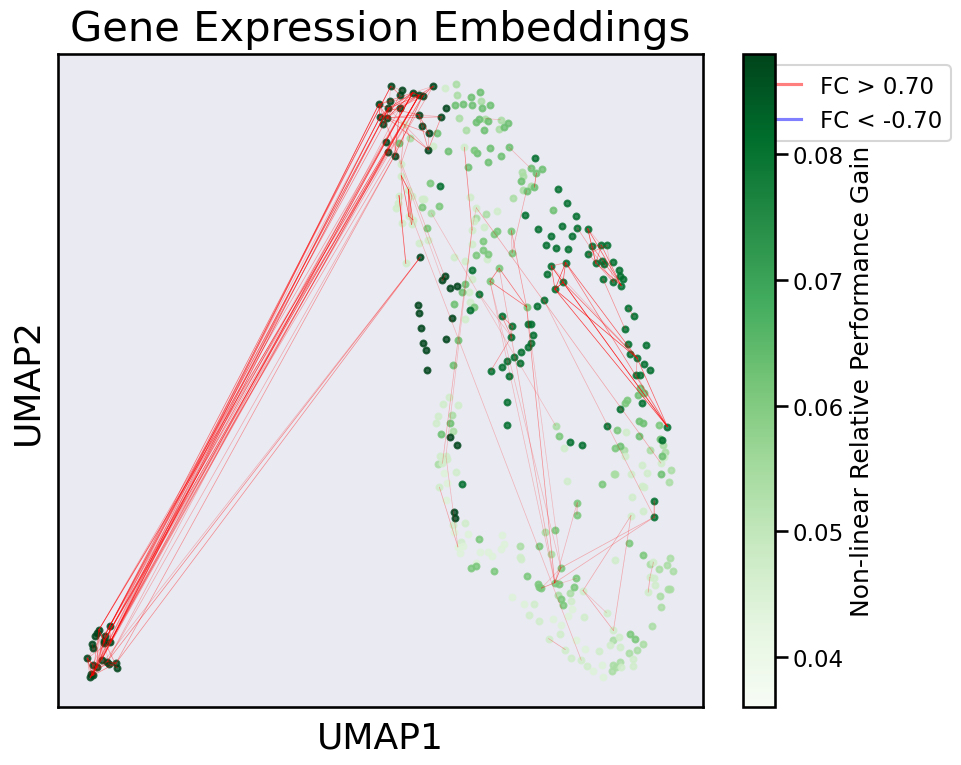

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  plt.colorbar(sm, label='Performance Gain (Pearson r)')



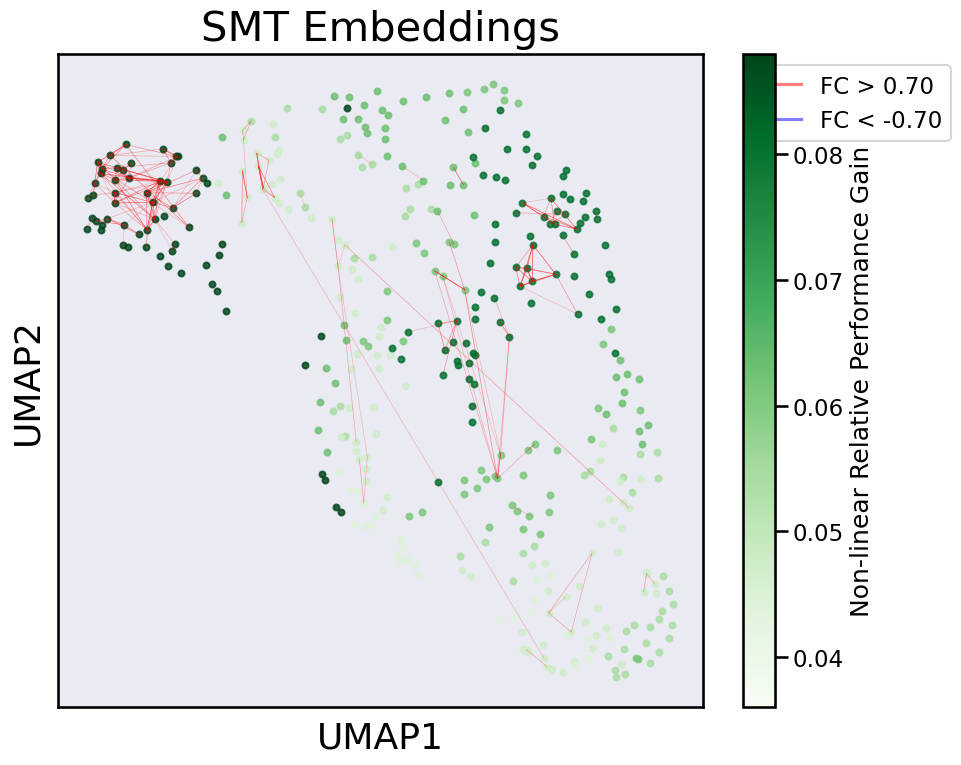

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  plt.colorbar(sm, label='Performance Gain (Pearson r)')



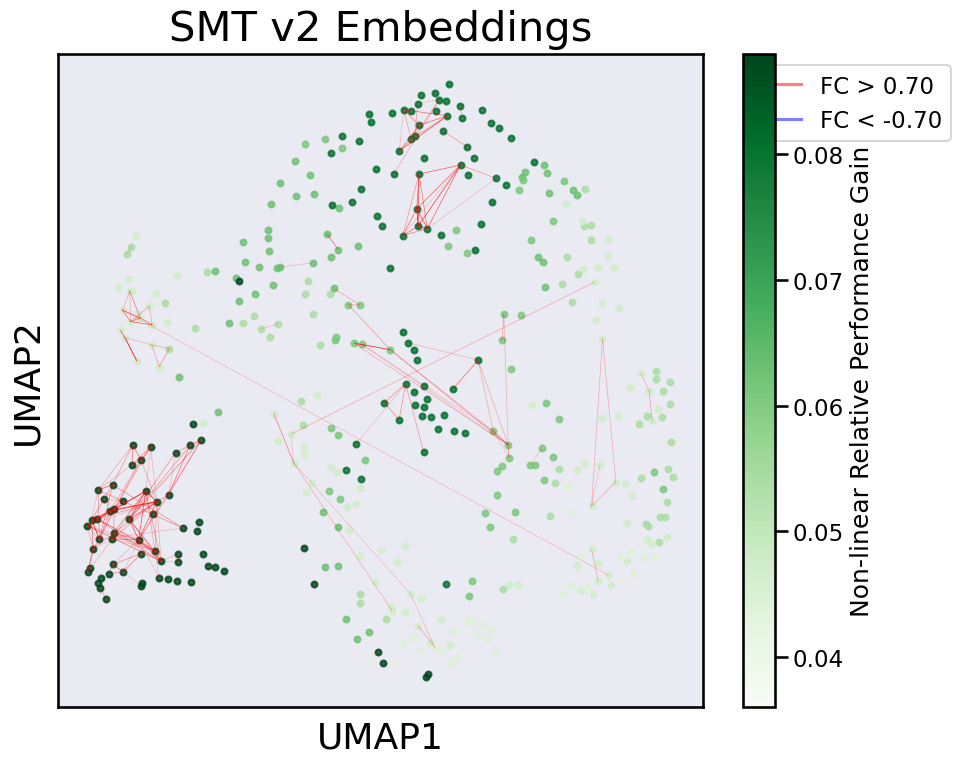

In [37]:
from data.data_viz import plot_coords_w_fc, plot_umap_embeddings_w_fc

omit_subcortical = True
neg_threshold, pos_threshold = -0.7, 0.7

coords_np = coords.cpu().numpy()
plot_coords_w_fc(coords_np, network_labels, dims=(1,2), conn_matrix=Y_valid, 
                 edge_threshold=(neg_threshold, pos_threshold), 
                 title="Y-Z View",
                 omit_subcortical=omit_subcortical, 
                 network_gains=mean_gains)

# Raw gene expression data
plot_umap_embeddings_w_fc(X_valid, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         title="Gene Expression Embeddings", 
                         omit_subcortical=omit_subcortical,
                         network_gains=mean_gains)

# SMT embeddings 
plot_umap_embeddings_w_fc(embeddings_smt, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         title="SMT Embeddings", 
                         omit_subcortical=omit_subcortical, flip_umap1=True,
                         network_gains=mean_gains)

# SMT v2 embeddings 
plot_umap_embeddings_w_fc(embeddings_smt_v2, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         title="SMT v2 Embeddings", 
                         omit_subcortical=omit_subcortical, flip_umap1=True, flip_umap2=True,
                         network_gains=mean_gains)

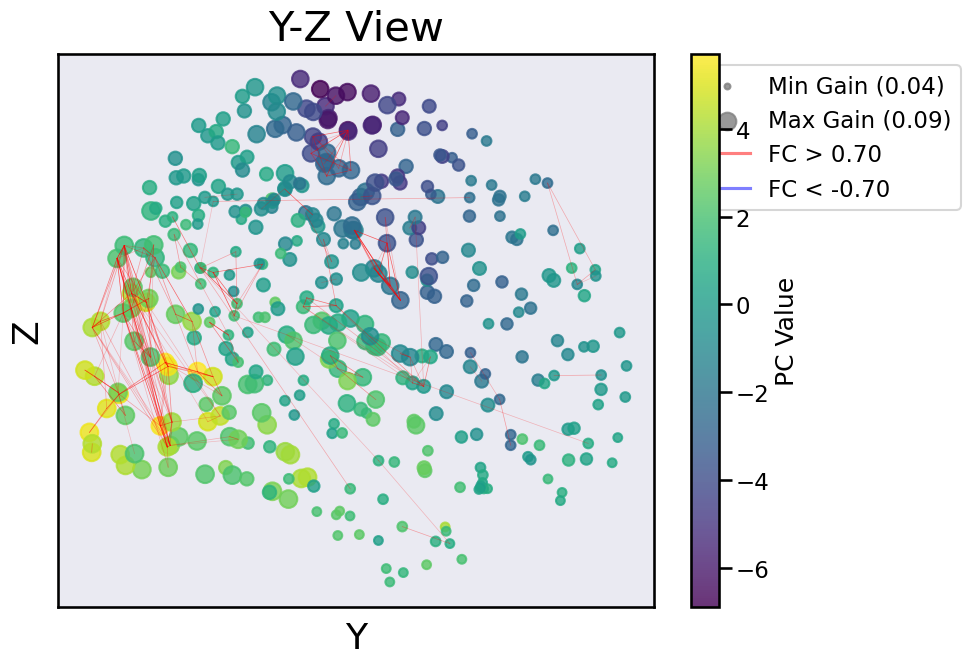

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



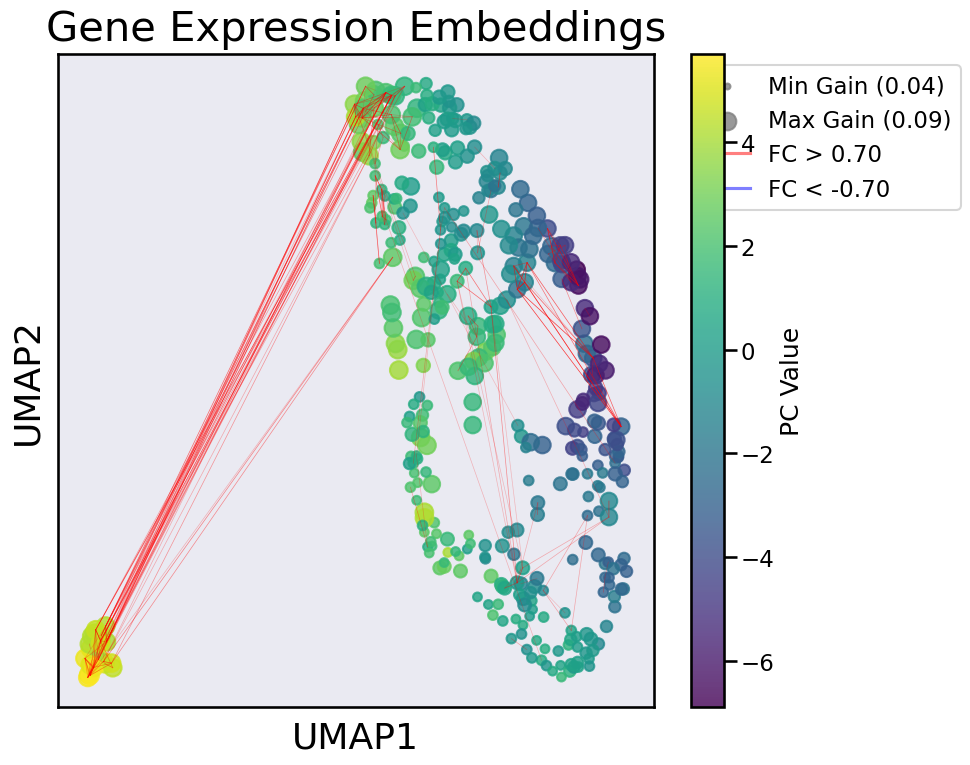

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



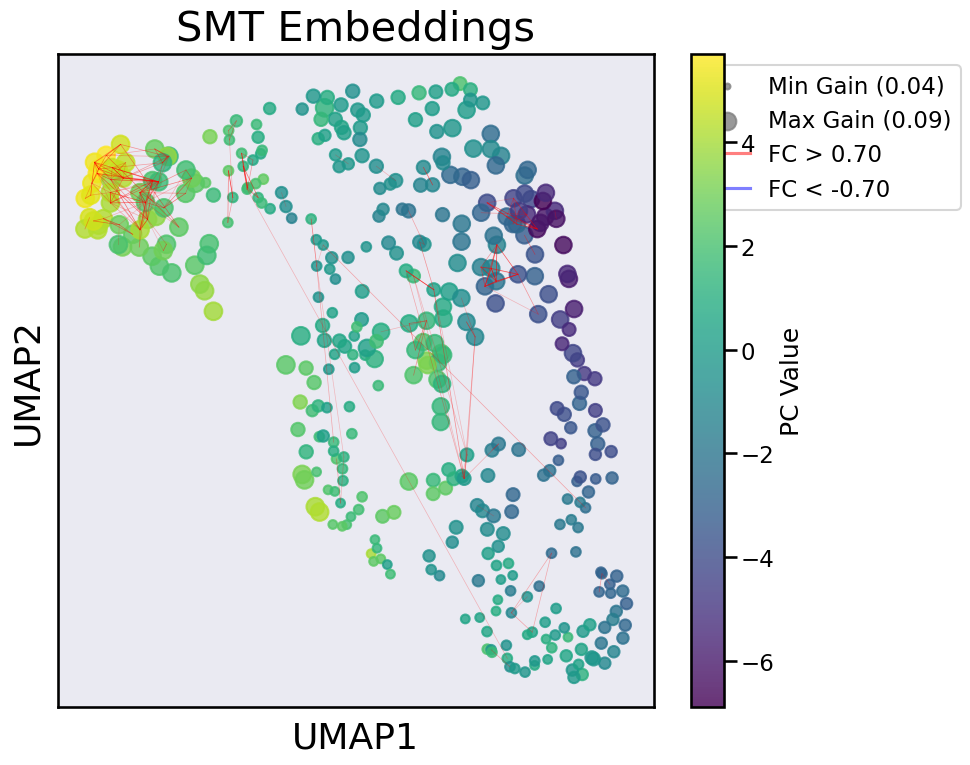

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



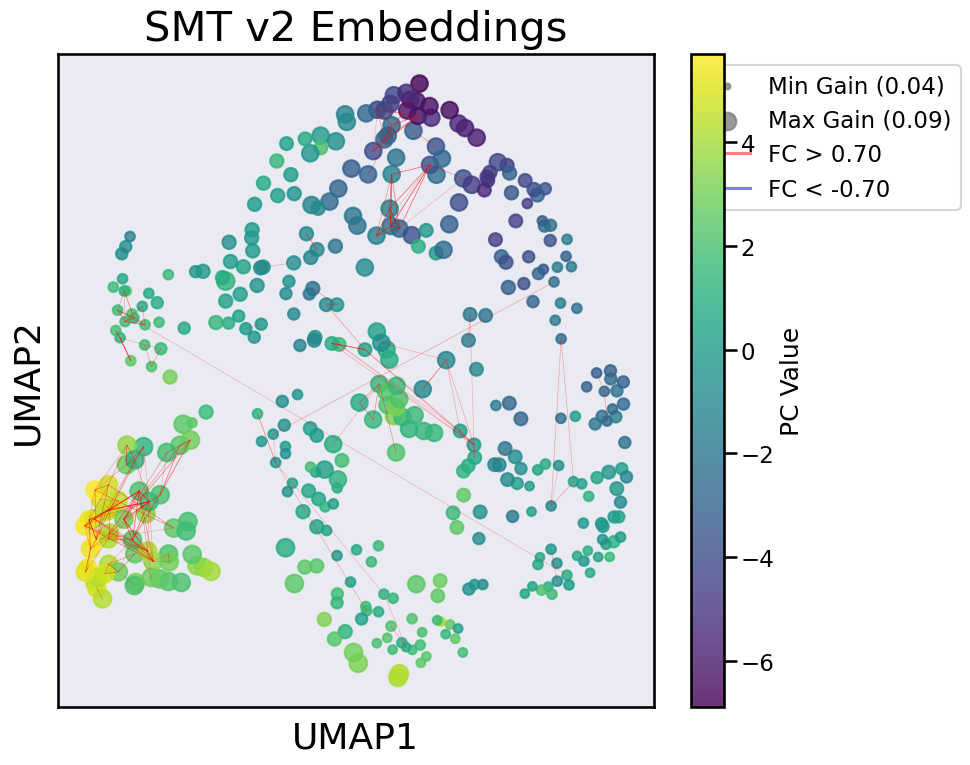

In [44]:
pc_values = X_pca[:, 2]
plot_coords_w_fc(coords_np, network_labels, dims=(1,2), conn_matrix=Y_valid, pc_values=pc_values, 
                 edge_threshold=(neg_threshold, pos_threshold), 
                 title="Y-Z View",
                 omit_subcortical=omit_subcortical,
                 network_gains=mean_gains)

# Raw gene expression data
plot_umap_embeddings_w_fc(X_valid, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         pc_values=pc_values,
                         title="Gene Expression Embeddings", 
                         omit_subcortical=omit_subcortical,
                         network_gains=mean_gains)

# SMT embeddings 
plot_umap_embeddings_w_fc(embeddings_smt, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         pc_values=pc_values,
                         title="SMT Embeddings", 
                         omit_subcortical=omit_subcortical, flip_umap1=True,
                         network_gains=mean_gains)

# SMT embeddings 
plot_umap_embeddings_w_fc(embeddings_smt_v2, network_labels, conn_matrix=Y_valid, 
                         edge_threshold=(neg_threshold, pos_threshold), 
                         pc_values=pc_values,
                         title="SMT v2 Embeddings", 
                         omit_subcortical=omit_subcortical, flip_umap1=True, flip_umap2=True,
                         network_gains=mean_gains)
